In [1]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
model = torchvision.models.resnet18(pretrained=True)
model.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 226MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False
)

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


In [4]:
failures = []

with torch.no_grad():
    for idx, (x, y) in enumerate(loader):
        logits = model(x)
        pred = logits.argmax(dim=1)

        if pred.item() != y.item():
            failures.append({
                "index": idx,
                "true_label": y.item(),
                "pred_label": pred.item()
            })

        if len(failures) >= 30:
            break

print(f"Collected {len(failures)} failure cases.")

Collected 30 failure cases.


In [5]:
def show_failure(sample):
    idx = sample["index"]
    img, label = dataset[idx]

    img_np = img.permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"True: {label}, Predicted: {sample['pred_label']}")
    plt.show()

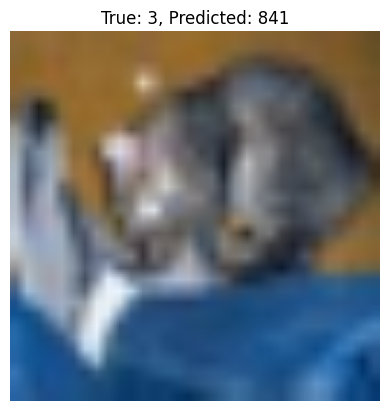

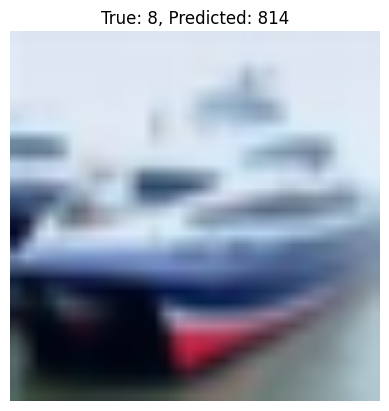

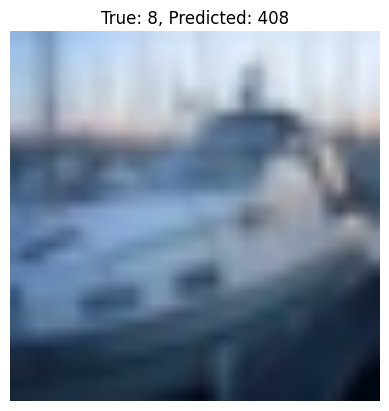

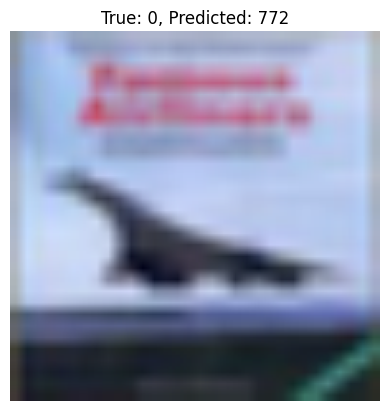

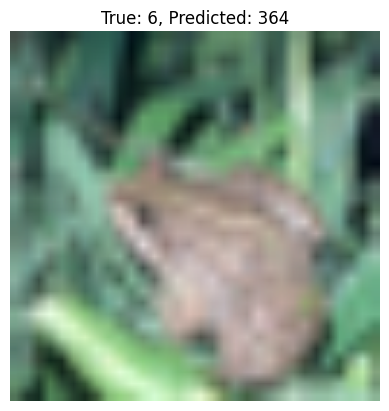

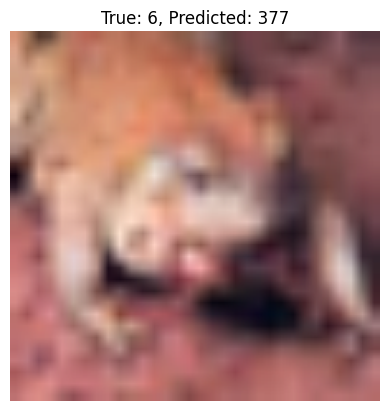

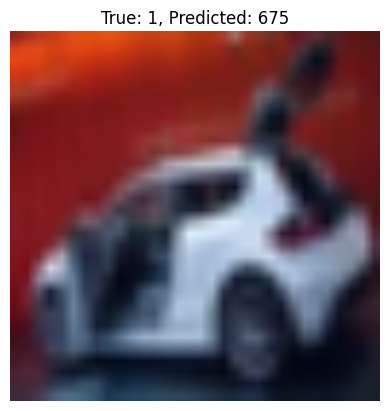

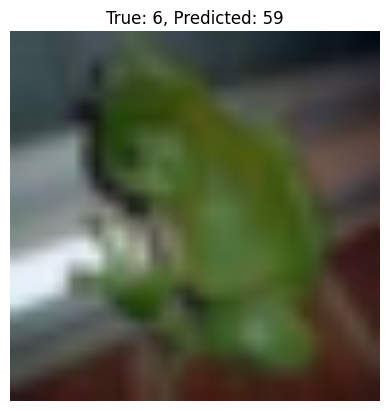

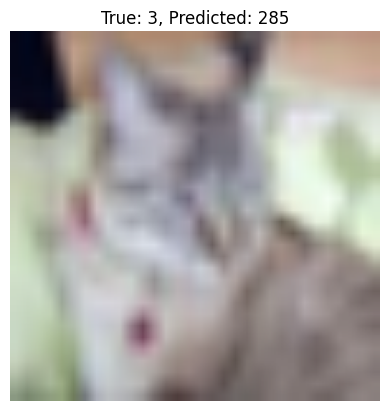

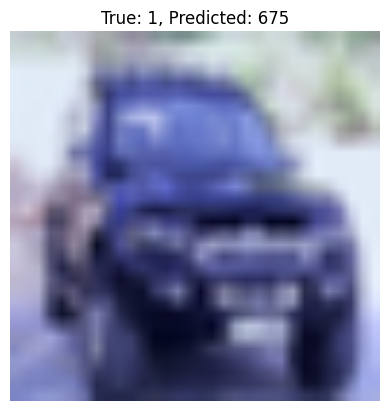

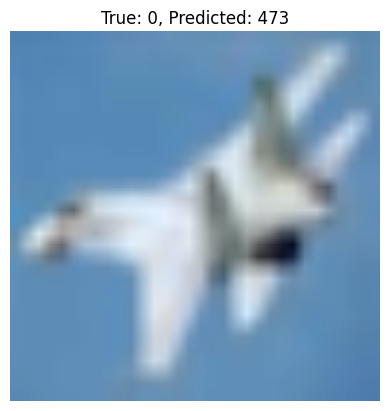

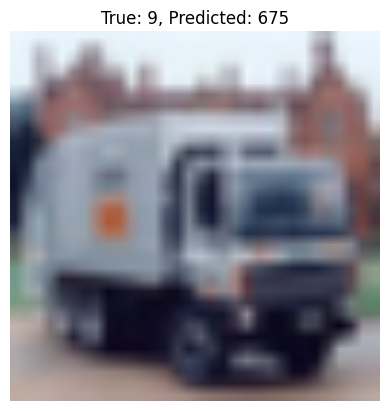

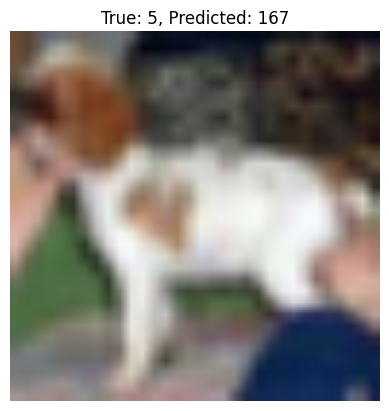

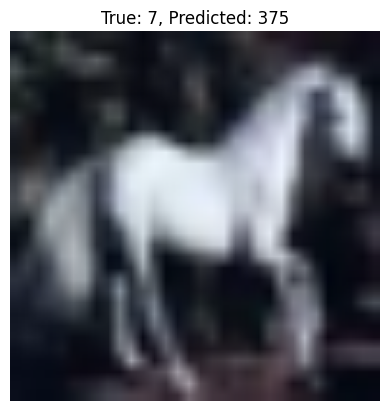

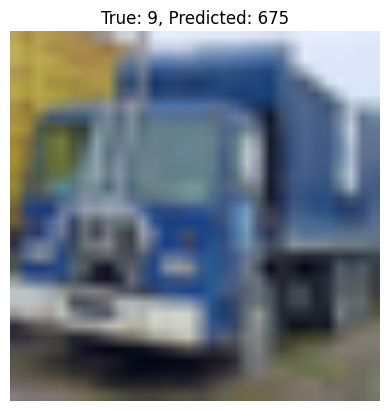

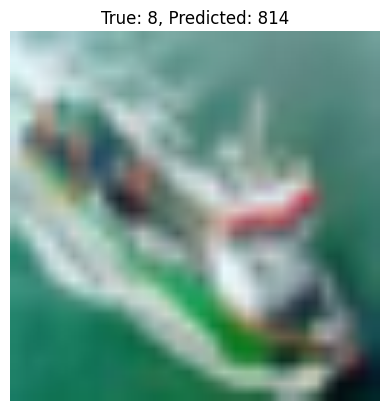

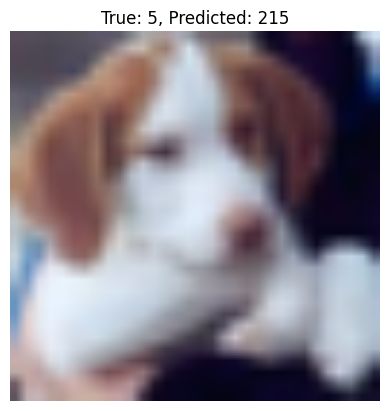

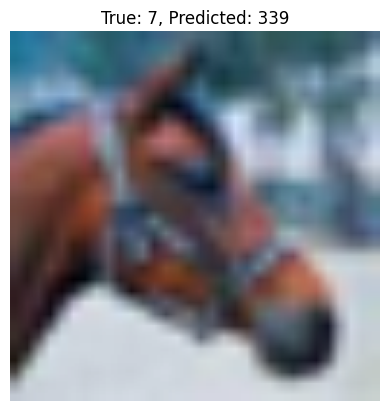

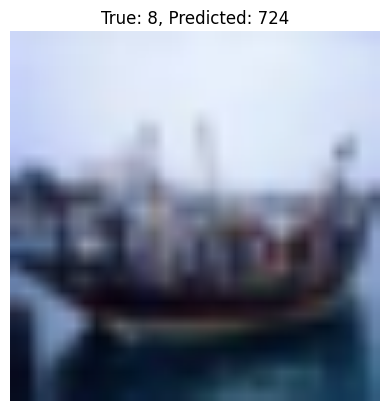

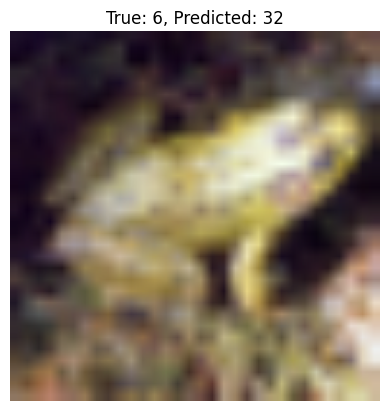

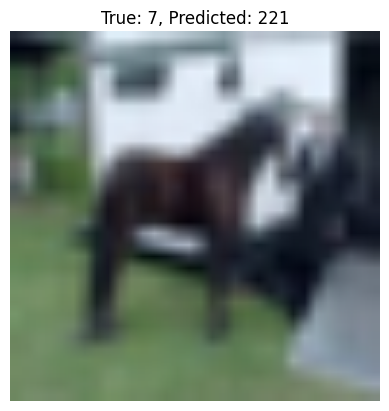

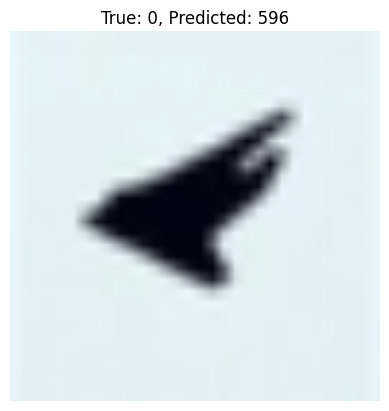

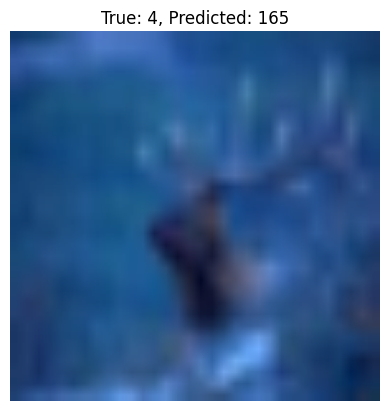

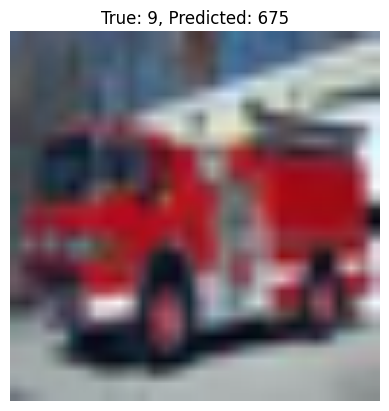

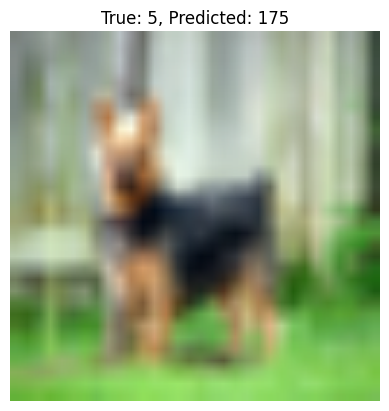

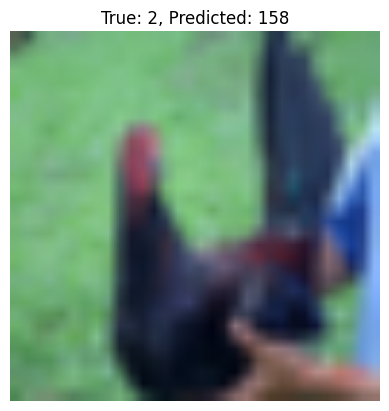

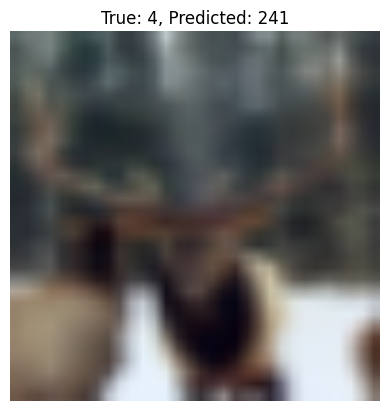

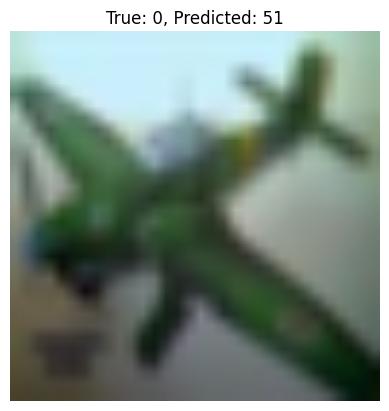

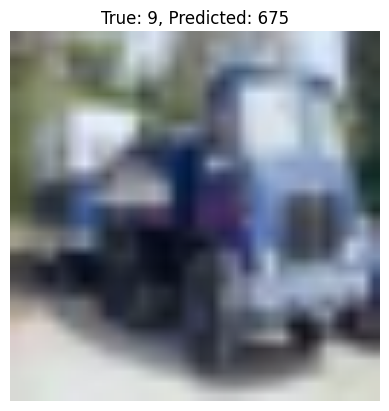

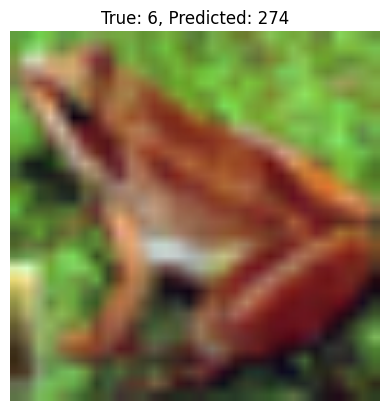

In [6]:
for f in failures:
    show_failure(f)

### Failure Mode Taxonomy

Each misclassified sample is manually assigned to one dominant failure mode:

1. **Occlusion / Partial Visibility** – object partially hidden or truncated  
2. **Scale Variation** – object too small or too large relative to image  
3. **Background Bias** – background dominates visual cues  
4. **Ambiguous Appearance** – visually similar to another class


Failure ID: 0


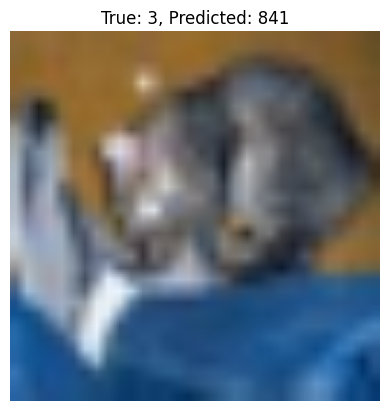

Failure ID: 1


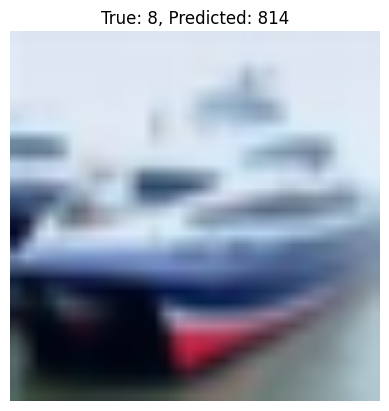

Failure ID: 2


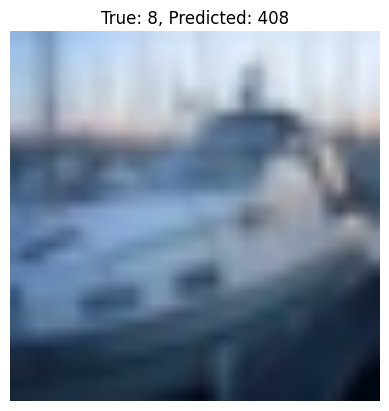

Failure ID: 3


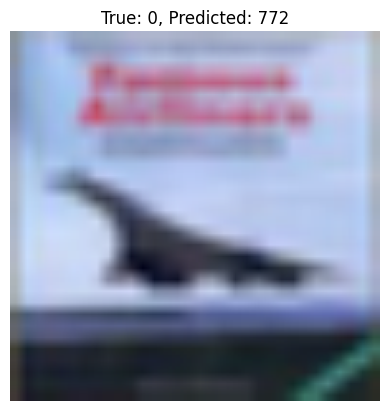

Failure ID: 4


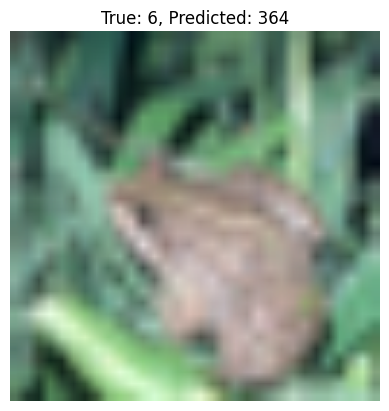

Failure ID: 5


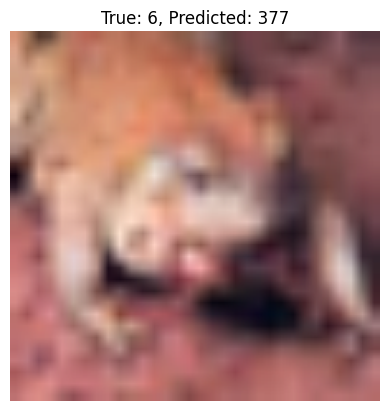

Failure ID: 6


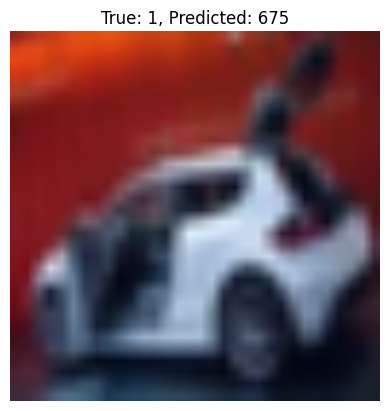

Failure ID: 7


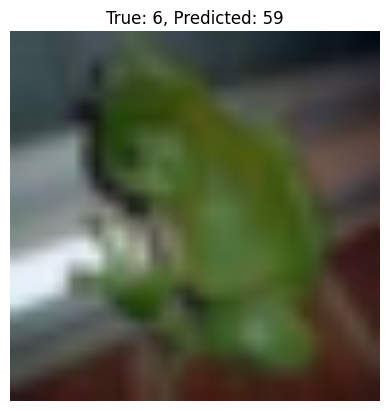

Failure ID: 8


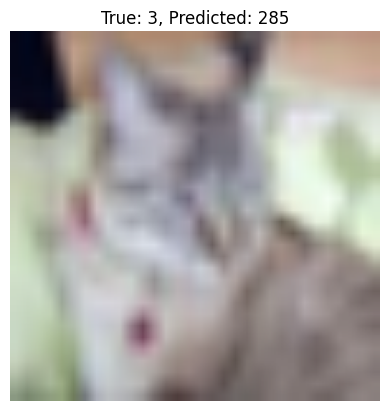

Failure ID: 9


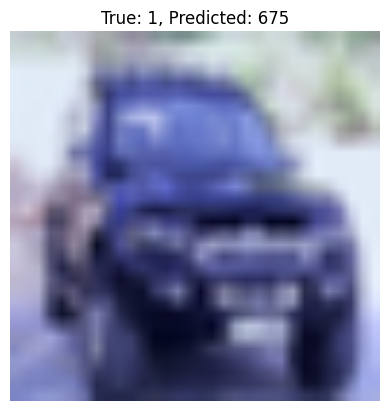

Failure ID: 10


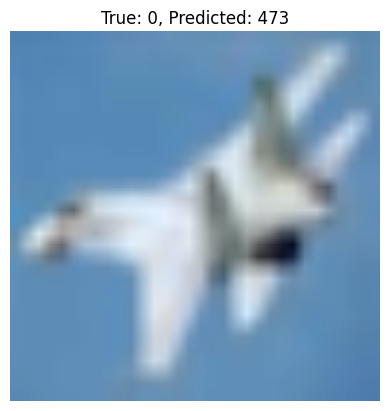

Failure ID: 11


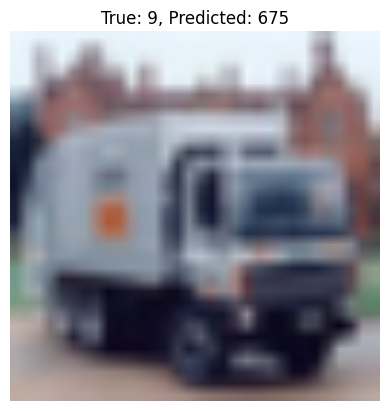

Failure ID: 12


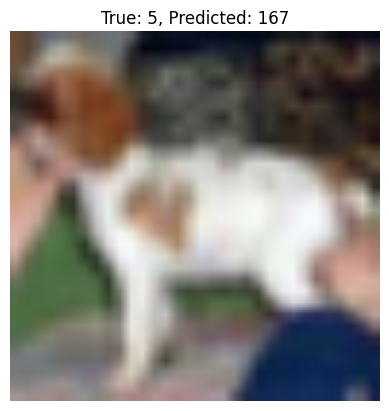

Failure ID: 13


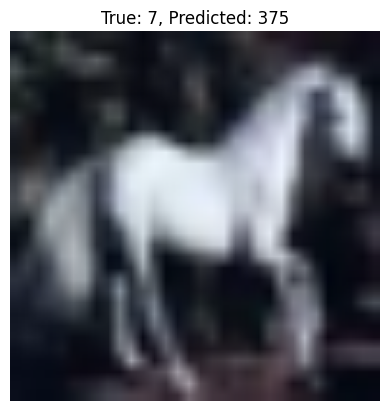

Failure ID: 14


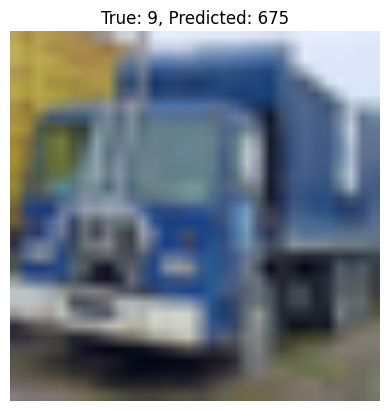

Failure ID: 15


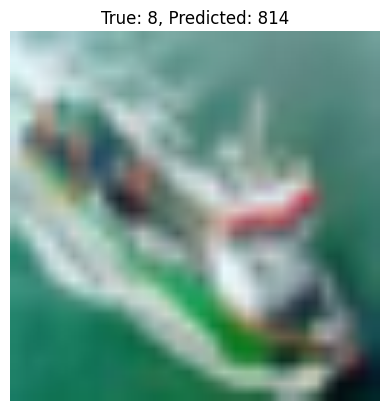

Failure ID: 16


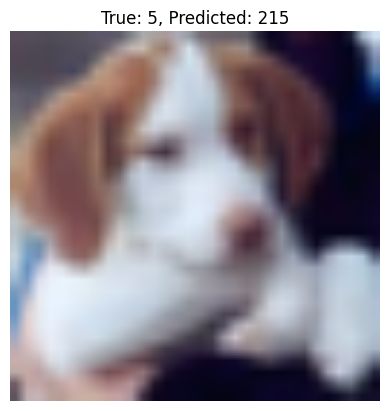

Failure ID: 17


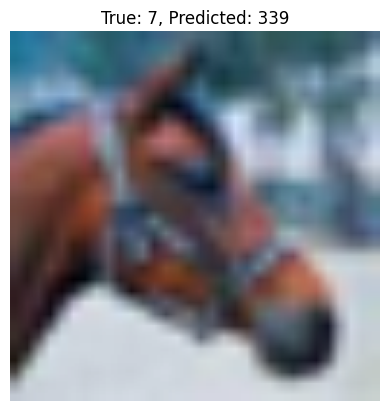

Failure ID: 18


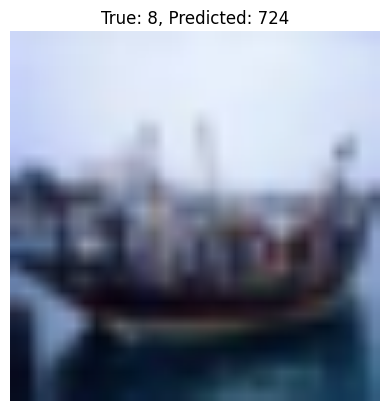

Failure ID: 19


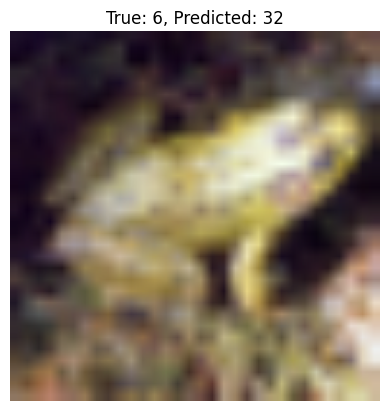

Failure ID: 20


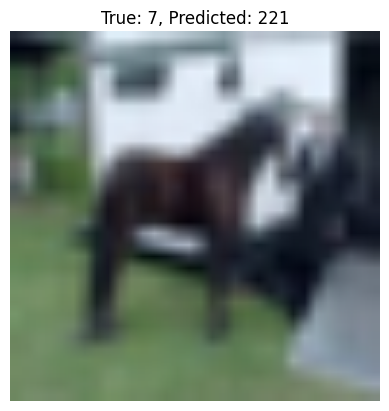

Failure ID: 21


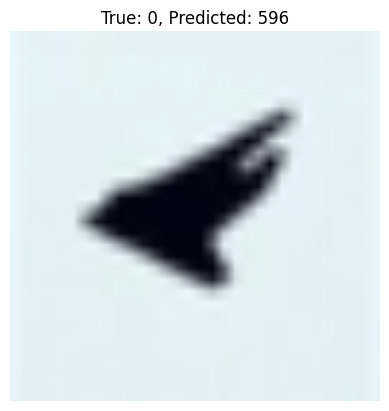

Failure ID: 22


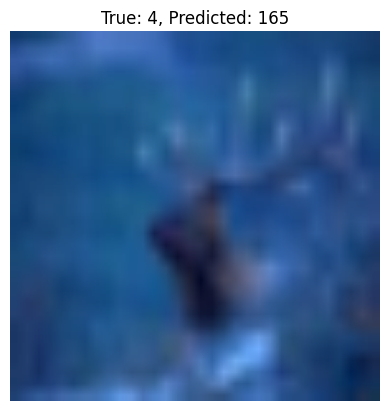

Failure ID: 23


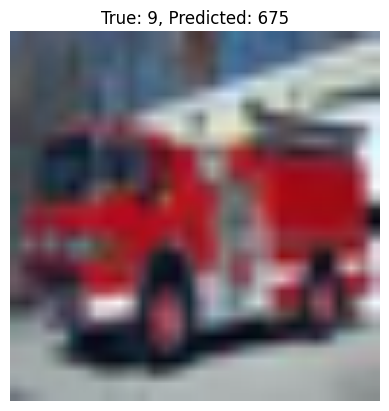

Failure ID: 24


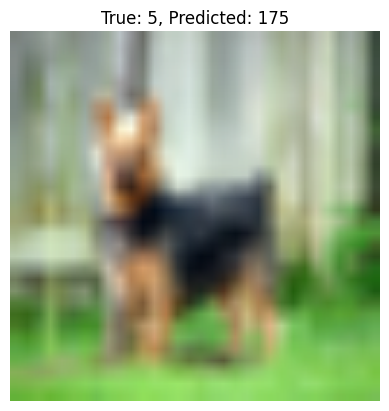

Failure ID: 25


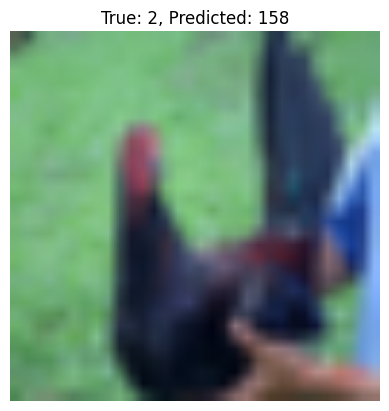

Failure ID: 26


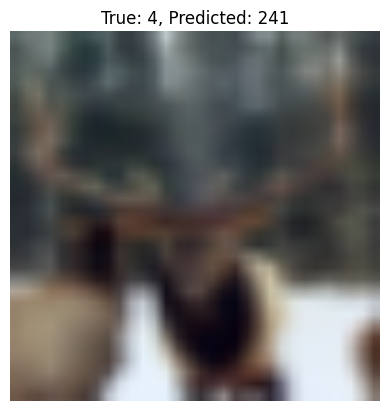

Failure ID: 27


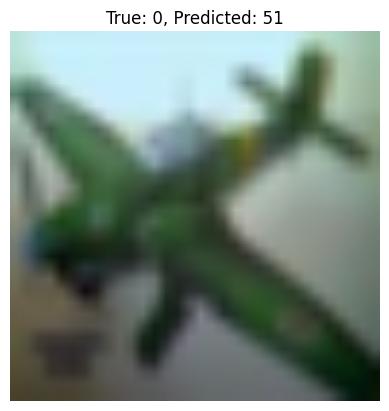

Failure ID: 28


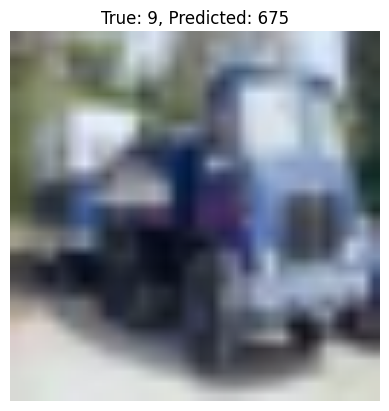

Failure ID: 29


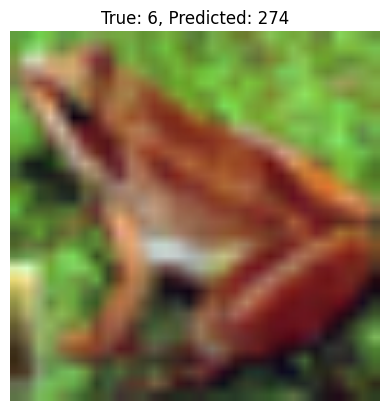

In [7]:
for i, f in enumerate(failures):
    print(f"Failure ID: {i}")
    show_failure(f)

In [8]:
labels = [
    "occlusion", "scale", "scale", "background", "background",
    "occlusion", "occlusion", "scale", "occlusion", "scale",
    "scale", "background", "occlusion", "background", "scale",
    "scale", "scale", "scale", "occlusion", "scale",
    "background", "background", "occlusion", "occlusion",
    "scale", "background", "scale", "scale", "background", "occlusion"
]

In [9]:
len(labels), len(failures)

(30, 30)

In [10]:
annotations = []

for f, mode in zip(failures, labels):
    annotations.append({
        "index": f["index"],
        "failure_mode": mode
    })

df = pd.DataFrame(annotations)
df.head()

index failure_mode
0      0    occlusion
1      1        scale
2      2        scale
3      3   background
4      4   background

In [11]:
df["failure_mode"].value_counts()

failure_mode
scale         13
occlusion      9
background     8
Name: count, dtype: int64

In [12]:
mode_counts = df["failure_mode"].value_counts()
mode_freq = df["failure_mode"].value_counts(normalize=True)

print("Counts:")
display(mode_counts)

print("\nProportions:")
display(mode_freq)

Counts:


failure_mode
scale         13
occlusion      9
background     8
Name: count, dtype: int64


Proportions:


failure_mode
scale         0.433333
occlusion     0.300000
background    0.266667
Name: proportion, dtype: float64

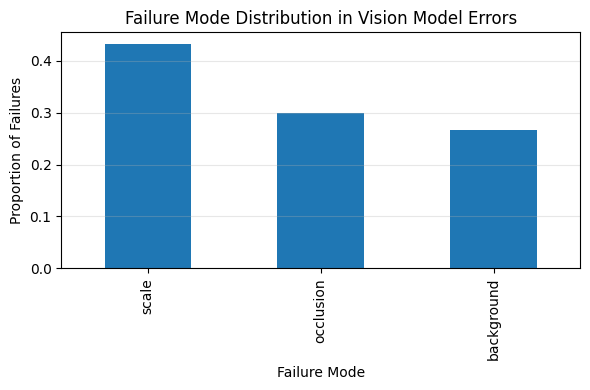

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
mode_freq.plot(kind="bar")

plt.ylabel("Proportion of Failures")
plt.xlabel("Failure Mode")
plt.title("Failure Mode Distribution in Vision Model Errors")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
df.to_csv("failure_annotations.csv", index=False)
print("Saved failure_annotations.csv")

Saved failure_annotations.csv


### Observations and Interpretation

The failure distribution shows that errors are dominated by scale-related effects, where effective resolution and feature quality are insufficient for reliable recognition. Background bias and occlusion also contribute substantially, indicating challenges in foreground–background separation and partial visibility.

These results suggest that model failures are structured rather than random. Failure mode analysis provides insights that aggregate accuracy metrics fail to capture and highlights concrete directions for improving robustness in vision models.